# 🌎 Welcome to the CSE151B Spring 2025 Climate Emulation Competition!

Thank you for participating in this exciting challenge focused on building machine learning models to emulate complex climate systems.  
This notebook is provided as a **starter template** to help you:

- Understand how to load and preprocess the dataset  
- Construct a baseline model  
- Train and evaluate predictions using a PyTorch Lightning pipeline  
- Format your predictions for submission to the leaderboard  

You're encouraged to:
- Build on this structure or replace it entirely
- Try more advanced models and training strategies
- Incorporate your own ideas to push the boundaries of what's possible

If you're interested in developing within a repository structure and/or use helpful tools like configuration management (based on Hydra) and logging (with Weights & Biases), we recommend checking out the following Github repo. Such a structure can be useful when running multiple experiments and trying various research ideas.

👉 [https://github.com/salvaRC/cse151b-spring2025-competition](https://github.com/salvaRC/cse151b-spring2025-competition)

Good luck, have fun, and we hope you learn a lot through this process!


### 📦 Install Required Libraries
We install the necessary Python packages for data loading, deep learning, and visualization.


In [1]:
%pip install xarray zarr dask lightning matplotlib wandb cftime einops vizarr


Defaulting to user installation because normal site-packages is not writeable
  Preparing metadata (setup.py) ... done
INFO: pip is looking at multiple versions of numcodecs[crc32c] to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.3/211.3 kB 15.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 220.7/220.7 kB 35.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 114.9 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 842.5/842.5 kB 66.8 MB/s eta 0:00:00
  Created wheel for asciitree: filename=asciitree-0.3.3-py3-none-any.whl size=5034 sha256=ff3163b54d4db3cb888e1eb4cbac0be500480916b6f872afb3d84be31dff5b52
  Stored in directory: /home/mpodgore/.cache/pip/wheels/71/c1/da/23077eb3b87d24d6f3852ed1ed1a1ac2d3c885ad6ebd2b4a07
Successfully built asciitree
  Attempting uninstall: numcodecs
    Found existing installation: numcodecs 0.16.0
    Uninstal

In [25]:
# lets visuzlize a zarr file
import vizarr
import zarr

In [26]:

import os
from datetime import datetime
import numpy as np
import pandas as pd
import xarray as xr
import dask.array as da
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import lightning.pytorch as pl
import pdb
import torch
import torch.nn as nn
import torch.nn.functional as F

### ⚙️ Configuration Setup  
Define all model, data, and training hyperparameters in one place for easy control and reproducibility.

### 📊 Data Configuration

We define the dataset settings used for training and evaluation. This includes:

- **`path`**: Path to the `.zarr` dataset containing monthly climate variables from CMIP6 simulations.
- **`input_vars`**: Climate forcing variables (e.g., CO₂, CH₄) used as model inputs.
- **`output_vars`**: Target variables to predict — surface air temperature (`tas`) and precipitation (`pr`).
- **`target_member_id`**: Ensemble member to use from the simulations (each SSP has 3) for target variables.
- **`train_ssps`**: SSP scenarios used for training (low to high emissions).
- **`test_ssp`**: Scenario held out for evaluation (Must be set to SSP245).
- **`test_months`**: Number of months to include in the test split (Must be set to 120).
- **`batch_size`** and **`num_workers`**: Data loading parameters for PyTorch training.

These settings reflect how the challenge is structured: models must learn from some emission scenarios and generalize to unseen ones.

> ⚠️ **Important:** Do **not modify** the following test settings:
>
> - `test_ssp` must remain **`ssp245`**, which is the held-out evaluation scenario.
> - `test_months` must be **`120`**, corresponding to the last 10 years (monthly resolution) of the scenario.



In [27]:
config= {
    "data": {
        "path": "processed_data_cse151b_v2_corrupted_ssp245/processed_data_cse151b_v2_corrupted_ssp245.zarr", #<- MAKE SURE THIS PATH IS CORRECT
        "input_vars": ["CO2", "SO2", "CH4", "BC", "rsdt"],
        "output_vars": ["tas", "pr"],
        "target_member_id": 0,
        "train_ssps": ["ssp126", "ssp370", "ssp585"],
        "test_ssp": "ssp245",
        "test_months": 360,
        "batch_size": 32, # Adjusted batch size for potentially larger UNET model
        "num_workers": 0,
    },
    "model": {
        "type": "simple_unet",
        "init_features": 64,
        "bilinear": True,
    },
    "training": {
        "lr": 1e-4, # Adjusted learning rate, often UNETs benefit from smaller LRs
    },
    "trainer": {
        "max_epochs": 18, # Increased epochs for potentially more complex model
        "accelerator": "auto",
        "devices": "auto",
        "precision": 16, # or 16 for mixed-precision if supported and beneficial
        "deterministic": True,
        "num_sanity_val_steps": 0, # Set to 2-3 for quick check during development
        # Consider adding logging, e.g. TensorBoardLogger
        # from lightning.pytorch.loggers import TensorBoardLogger
        # logger = TensorBoardLogger("tb_logs", name="simple_unet_climate")
    },
    "seed": 42,
}
pl.seed_everything(config["seed"])

Seed set to 42


42

In [28]:
#NOTE Change the data directory according to where you have your zarr files stored
config_cnn = {
    "data": {
        "path": "processed_data_cse151b_v2_corrupted_ssp245/processed_data_cse151b_v2_corrupted_ssp245.zarr",
        "input_vars": ["CO2", "SO2", "CH4", "BC", "rsdt"],
        "output_vars": ["tas", "pr"],
        "target_member_id": 0,
        "train_ssps": ["ssp126", "ssp370", "ssp585"],
        "test_ssp": "ssp245",
        "test_months": 360,
        "batch_size": 64,
        "num_workers": 0,
    },
    "model": {
        "type": "simple_cnn",
        "kernel_size": 3,
        "init_dim": 64,
        "depth": 4,
        "dropout_rate": 0.1,
    },
    "training": {
        "lr": 1e-3,
    },
    "trainer": {
        "max_epochs": 10,
        "accelerator": "auto",
        "devices": "auto",
        "precision": 32,
        "deterministic": True,
        "num_sanity_val_steps": 0,
        
    },
    "seed": 42,
}
pl.seed_everything(config["seed"])  # Set seed for reproducibility

Seed set to 42


42

### 🔧 Spatial Weighting Utility Function

This cell sets up utility functions for reproducibility and spatial weighting:

- **`get_lat_weights(latitude_values)`**: Computes cosine-based area weights for each latitude, accounting for the Earth's curvature. This is critical for evaluating global climate metrics fairly — grid cells near the equator represent larger surface areas than those near the poles.


In [29]:
def get_lat_weights(latitude_values):
    lat_rad = np.deg2rad(latitude_values)
    weights = np.cos(lat_rad)
    return weights / np.mean(weights)

### 🧠 SimpleCNN: A Residual Convolutional Baseline

This is a lightweight baseline model designed to capture spatial patterns in global climate data using convolutional layers.

- The architecture starts with a **convolution + batch norm + ReLU** block to process the input channels.
- It then applies a series of **residual blocks** to extract increasingly abstract spatial features. These help preserve gradient flow during training.
- Finally, a few convolutional layers reduce the feature maps down to the desired number of output channels (`tas` and `pr`).

This model only serves as a **simple baseline for climate emulation**. 

We encourage you to build and experiment with your own models and ideas.


In [30]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size, stride=stride, padding=kernel_size // 2)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size, padding=kernel_size // 2)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.skip = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.skip = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride), nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        identity = x
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.skip(identity)
        return self.relu(out)

class SimpleCNN(nn.Module):
    def __init__(self, n_input_channels, n_output_channels, kernel_size=3, init_dim=64, depth=4, dropout_rate=0.2):
        super().__init__()
        self.initial = nn.Sequential(
            nn.Conv2d(n_input_channels, init_dim, kernel_size=kernel_size, padding=kernel_size // 2),
            nn.BatchNorm2d(init_dim),
            nn.ReLU(inplace=True),
        )
        self.res_blocks = nn.ModuleList()
        current_dim = init_dim
        for i in range(depth):
            out_dim = current_dim * 2 if i < depth - 1 else current_dim
            self.res_blocks.append(ResidualBlock(current_dim, out_dim))
            if i < depth - 1:
                current_dim *= 2
        self.dropout = nn.Dropout2d(dropout_rate)
        self.final = nn.Sequential(
            nn.Conv2d(current_dim, current_dim // 2, kernel_size=kernel_size, padding=kernel_size // 2),
            nn.BatchNorm2d(current_dim // 2),
            nn.ReLU(inplace=True),
            nn.Conv2d(current_dim // 2, n_output_channels, kernel_size=1),
        )

    def forward(self, x):
        x = self.initial(x)
        for res_block in self.res_blocks:
            x = res_block(x)
        return self.final(self.dropout(x))


In [31]:
## implement a unet class
# we will have 2 convilution, then we down sample, and then up, and last outer convolution


class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)

class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels_skip, in_channels_prev_decoder, out_channels_decoder, bilinear=True):
        super().__init__()
        self.bilinear = bilinear
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels_prev_decoder + in_channels_skip, out_channels_decoder)
        else:
            self.up = nn.ConvTranspose2d(in_channels_prev_decoder, in_channels_prev_decoder // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv((in_channels_prev_decoder // 2) + in_channels_skip, out_channels_decoder)

    def forward(self, x_prev_decoder, x_skip):
        x_up = self.up(x_prev_decoder)

        # Pad x_up to match x_skip dimensions if necessary
        # input is B, C, H, W
        diffY = x_skip.size()[2] - x_up.size()[2]
        diffX = x_skip.size()[3] - x_up.size()[3]

        # Apply padding: (padding_left, padding_right, padding_top, padding_bottom)
        x_up = F.pad(x_up, [diffX // 2, diffX - diffX // 2,
                            diffY // 2, diffY - diffY // 2])

        x = torch.cat([x_skip, x_up], dim=1)
        return self.conv(x)

class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

class SimpleUNET(nn.Module):
    def __init__(self, n_input_channels, n_output_channels, bilinear=True, init_features=64):
        """
        A simple UNET model.
        Args:
            n_input_channels (int): Number of input channels (e.g., 5 for the climate variables).
            n_output_channels (int): Number of output channels (e.g., 2 for 'tas' and 'pr').
            bilinear (bool): Whether to use bilinear upsampling or ConvTranspose2d.
            init_features (int): Number of channels in the first convolutional layer.
                                 Channels will double at each downsampling stage.
        """
        super(SimpleUNET, self).__init__()
        self.n_input_channels = n_input_channels
        self.n_output_channels = n_output_channels
        self.bilinear = bilinear
        f = init_features

        # Encoder path
        self.inc = DoubleConv(n_input_channels, f)     # Output: (B, f, H, W)
        self.down1 = Down(f, f*2)                       # Output: (B, 2f, H/2, W/2)
        self.down2 = Down(f*2, f*4)                     # Output: (B, 4f, H/4, W/4)
        self.down3 = Down(f*4, f*8)                     # Bottleneck: (B, 8f, H/8, W/8)

        # Decoder path
        self.up1 = Up(f*4, f*8, f*4, bilinear)
        self.up2 = Up(f*2, f*4, f*2, bilinear)
        self.up3 = Up(f, f*2, f, bilinear)

        self.outc = OutConv(f, n_output_channels)       # Final output layer

    def forward(self, x):
        # Encoder
        x1_skip = self.inc(x)
        x2_skip = self.down1(x1_skip)
        x3_skip = self.down2(x2_skip)
        bottleneck = self.down3(x3_skip)

        # Decoder
        dec1 = self.up1(bottleneck, x3_skip)
        dec2 = self.up2(dec1, x2_skip)
        dec3 = self.up3(dec2, x1_skip)

        logits = self.outc(dec3)
        return logits   

### 📐 Normalizer: Z-Score Scaling for Climate Inputs & Outputs

This class handles **Z-score normalization**, a crucial preprocessing step for stable and efficient neural network training:

- **`set_input_statistics(mean, std)` / `set_output_statistics(...)`**: Store the mean and standard deviation computed from the training data for later use.
- **`normalize(data, data_type)`**: Standardizes the data using `(x - mean) / std`. This is applied separately to inputs and outputs.
- **`inverse_transform_output(data)`**: Converts model predictions back to the original physical units (e.g., Kelvin for temperature, mm/day for precipitation).

Normalizing the data ensures the model sees inputs with similar dynamic ranges and avoids biases caused by different variable scales.


In [32]:
class Normalizer:
    def __init__(self):
        self.mean_in, self.std_in = None, None
        self.mean_out, self.std_out = None, None

    def set_input_statistics(self, mean, std):
        self.mean_in = mean
        self.std_in = std

    def set_output_statistics(self, mean, std):
        self.mean_out = mean
        self.std_out = std

    def normalize(self, data, data_type):
        if data_type == "input":
            return (data - self.mean_in) / self.std_in
        elif data_type == "output":
            return (data - self.mean_out) / self.std_out

    def inverse_transform_output(self, data):
        return data * self.std_out + self.mean_out


### 🌍 Data Module: Loading, Normalization, and Splitting

This section handles the entire data pipeline, from loading the `.zarr` dataset to preparing PyTorch-ready DataLoaders.

#### `ClimateDataset`
- A simple PyTorch `Dataset` wrapper that preloads the entire (normalized) dataset into memory using Dask.
- Converts the data to PyTorch tensors and handles any `NaN` checks up front.

#### `ClimateDataModule`
A PyTorch Lightning `DataModule` that handles:
- ✅ **Loading data** from different SSP scenarios and ensemble members
- ✅ **Broadcasting non-spatial inputs** (like CO₂) to match spatial grid size
- ✅ **Normalization** using mean/std computed from training data only
- ✅ **Splitting** into training, validation, and test sets:
  - Training: All months from selected SSPs (except last 10 years of SSP370)
  - Validation: Last 10 years (120 months) of SSP370
  - Test: Last 10 years of SSP245 (unseen scenario)
- ✅ **Batching** and parallelized data loading via PyTorch `DataLoader`s
- ✅ **Latitude-based area weighting** for fair climate metric evaluation
- Shape of the inputs are Batch_Size X 5 (num_input_variables) X 48 X 72
- Shape of ouputputs are Batch_Size X 2 (num_output_variables) X 48 X 72

> ℹ️ **Note:** You likely won’t need to modify this class but feel free to make modifications if you want to inlcude different ensemble mebers to feed more data to your models


In [33]:


class ClimateDataset(Dataset):
    def __init__(self, inputs_dask, outputs_dask, output_is_normalized=True):
        self.size = inputs_dask.shape[0]
        print(f"Creating dataset with {self.size} samples...")

        inputs_np = inputs_dask.compute()
        outputs_np = outputs_dask.compute()

        self.inputs = torch.from_numpy(inputs_np).float()
        self.outputs = torch.from_numpy(outputs_np).float()

        if torch.isnan(self.inputs).any() or torch.isnan(self.outputs).any():
            raise ValueError("NaNs found in dataset")

    def __len__(self):
        return self.size

    def __getitem__(self, idx):
        return self.inputs[idx], self.outputs[idx]


class ClimateDataModule(pl.LightningDataModule):
    def __init__(
        self,
        path,
        input_vars,
        output_vars,
        train_ssps,
        test_ssp,
        target_member_id,
        val_split=0.1,
        test_months=120,
        batch_size=32,
        num_workers=0,
        seed=42,
    ):
        super().__init__()
        self.path = path
        self.input_vars = input_vars
        self.output_vars = output_vars
        self.train_ssps = train_ssps
        self.test_ssp = test_ssp
        self.target_member_id = target_member_id
        self.val_split = val_split
        self.test_months = test_months
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.seed = seed
        self.normalizer = Normalizer()

    def prepare_data(self):
        assert os.path.exists(self.path), f"Data path not found: {self.path}"

    def setup(self, stage=None):
        ds = xr.open_zarr(self.path, consolidated=False, chunks={"time": 24})
        spatial_template = ds["rsdt"].isel(time=0, ssp=0, drop=True)

        def load_ssp(ssp):
            input_dask, output_dask = [], []
            for var in self.input_vars:
                da_var = ds[var].sel(ssp=ssp)
                if "latitude" in da_var.dims:
                    da_var = da_var.rename({"latitude": "y", "longitude": "x"})
                if "member_id" in da_var.dims:
                    da_var = da_var.sel(member_id=self.target_member_id)
                if set(da_var.dims) == {"time"}:
                    da_var = da_var.broadcast_like(spatial_template).transpose("time", "y", "x")
                input_dask.append(da_var.data)

            for var in self.output_vars:
                da_out = ds[var].sel(ssp=ssp, member_id=self.target_member_id)
                if "latitude" in da_out.dims:
                    da_out = da_out.rename({"latitude": "y", "longitude": "x"})
                output_dask.append(da_out.data)

            return da.stack(input_dask, axis=1), da.stack(output_dask, axis=1)

        train_input, train_output, val_input, val_output = [], [], None, None

        for ssp in self.train_ssps:
            x, y = load_ssp(ssp)
            if ssp == "ssp370":
                val_input = x[-self.test_months:]
                val_output = y[-self.test_months:]
                train_input.append(x[:-self.test_months])
                train_output.append(y[:-self.test_months])
            else:
                train_input.append(x)
                train_output.append(y)

        train_input = da.concatenate(train_input, axis=0)
        train_output = da.concatenate(train_output, axis=0)

        self.normalizer.set_input_statistics(
            mean=da.nanmean(train_input, axis=(0, 2, 3), keepdims=True).compute(),
            std=da.nanstd(train_input, axis=(0, 2, 3), keepdims=True).compute(),
        )
        self.normalizer.set_output_statistics(
            mean=da.nanmean(train_output, axis=(0, 2, 3), keepdims=True).compute(),
            std=da.nanstd(train_output, axis=(0, 2, 3), keepdims=True).compute(),
        )

        train_input_norm = self.normalizer.normalize(train_input, "input")
        train_output_norm = self.normalizer.normalize(train_output, "output")
        val_input_norm = self.normalizer.normalize(val_input, "input")
        val_output_norm = self.normalizer.normalize(val_output, "output")

        test_input, test_output = load_ssp(self.test_ssp)
        test_input = test_input[-self.test_months:]
        test_output = test_output[-self.test_months:]
        test_input_norm = self.normalizer.normalize(test_input, "input")

        self.train_dataset = ClimateDataset(train_input_norm, train_output_norm)
        self.val_dataset = ClimateDataset(val_input_norm, val_output_norm)
        self.test_dataset = ClimateDataset(test_input_norm, test_output, output_is_normalized=False)

        self.lat = spatial_template.y.values
        self.lon = spatial_template.x.values
        self.area_weights = xr.DataArray(get_lat_weights(self.lat), dims=["y"], coords={"y": self.lat})

    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True,
                          num_workers=self.num_workers, pin_memory=True)

    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size, shuffle=False,
                          num_workers=self.num_workers, pin_memory=True)

    def test_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=self.batch_size, shuffle=False,
                          num_workers=self.num_workers, pin_memory=True)

    def get_lat_weights(self):
        return self.area_weights

    def get_coords(self):
        return self.lat, self.lon

In [34]:
cdm = ClimateDataModule(
    path=config["data"]["path"],
    input_vars=config["data"]["input_vars"],
    output_vars=config["data"]["output_vars"],
    train_ssps=config["data"]["train_ssps"],
    test_ssp=config["data"]["test_ssp"],
    target_member_id=config["data"]["target_member_id"],
    test_months=config["data"]["test_months"],
    batch_size=config["data"]["batch_size"],
    num_workers=config["data"]["num_workers"],
)
cdm.setup()
# print the shape of train, validation, and test datasets
print(f"Train dataset shape: {len(cdm.train_dataset)}, {cdm.train_dataset.outputs.shape}")
print(f"Validation dataset shape: {cdm.val_dataset.inputs.shape}, {cdm.val_dataset.outputs.shape}")
print(f"Test dataset shape: {cdm.test_dataset.inputs.shape}, {cdm.test_dataset.outputs.shape}")



Creating dataset with 2703 samples...
Creating dataset with 360 samples...
Creating dataset with 360 samples...
Train dataset shape: 2703, torch.Size([2703, 2, 48, 72])
Validation dataset shape: torch.Size([360, 5, 48, 72]), torch.Size([360, 2, 48, 72])
Test dataset shape: torch.Size([360, 5, 48, 72]), torch.Size([360, 2, 48, 72])


# Lets visualize the distribution of output variables

In [35]:
out_vars = cdm.output_vars
in_vars = cdm.input_vars
print(f"Input variables: {in_vars}")
print(f"Output variables: {out_vars}")

Input variables: ['CO2', 'SO2', 'CH4', 'BC', 'rsdt']
Output variables: ['tas', 'pr']


In [36]:
ds = xr.open_zarr(config["data"]["path"], consolidated=False, chunks={"time": 24})
print(ds)
             

<xarray.Dataset> Size: 621MB
Dimensions:    (ssp: 4, time: 1021, latitude: 48, longitude: 72, x: 72, y: 48,
                member_id: 3)
Coordinates:
    lat        (x, y) float64 28kB dask.array<chunksize=(72, 48), meta=np.ndarray>
  * latitude   (latitude) float64 384B -89.05 -85.26 -81.47 ... 85.26 89.05
    lon        (x, y) float64 28kB dask.array<chunksize=(72, 48), meta=np.ndarray>
  * longitude  (longitude) float64 576B 1.25 6.25 11.25 ... 346.2 351.2 356.2
  * member_id  (member_id) int64 24B 0 1 2
  * ssp        (ssp) <U6 96B 'ssp126' 'ssp245' 'ssp370' 'ssp585'
  * time       (time) object 8kB 2015-01-15 00:00:00 ... 2100-01-15 00:00:00
  * x          (x) float64 576B 1.875 6.875 11.88 16.88 ... 346.9 351.9 356.9
  * y          (y) float64 384B -88.59 -84.82 -81.05 ... 81.05 84.82 88.59
Data variables:
    BC         (ssp, time, latitude, longitude) float64 113MB dask.array<chunksize=(1, 24, 48, 72), meta=np.ndarray>
    CH4        (ssp, time) float64 33kB dask.array<chunksi

In [37]:
# SSP are shared social pathways, they describe different scenarios of greenhouse gas emissions and land use changes
print(ds['ssp'].values)

# These are monthly values, so the time dimension is 12 months per year
print(ds['time'].values[:2])

# The latitude and longitude dimensions are the grid points of the model
print(ds['latitude'].values[:2])
print(ds['longitude'].values[:2])

['ssp126' 'ssp245' 'ssp370' 'ssp585']
[cftime.DatetimeNoLeap(2015, 1, 15, 0, 0, 0, 0, has_year_zero=True)
 cftime.DatetimeNoLeap(2015, 2, 15, 0, 0, 0, 0, has_year_zero=True)]
[-89.05263158 -85.26315789]
[1.25 6.25]


In [38]:
train_output = cdm.train_dataset.outputs
print(f"Train output shape: {train_output.shape}")

Train output shape: torch.Size([2703, 2, 48, 72])


In [39]:
train_input = cdm.train_dataset.inputs
print(f"Train input shape: {train_input.shape}")

Train input shape: torch.Size([2703, 5, 48, 72])


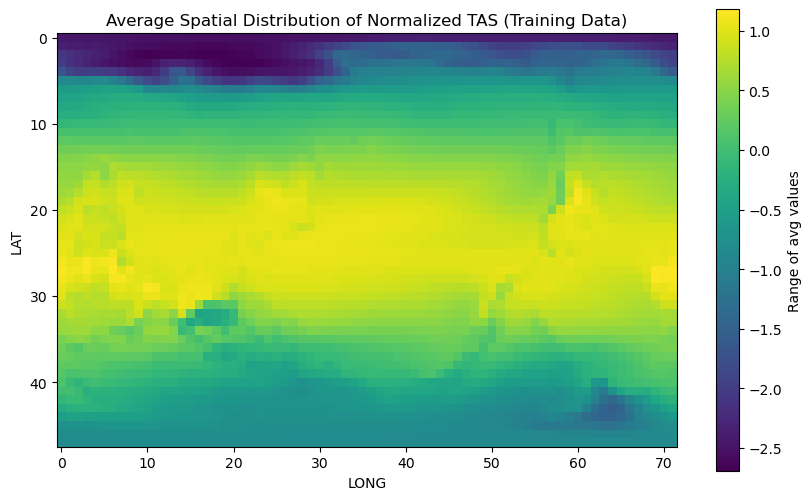

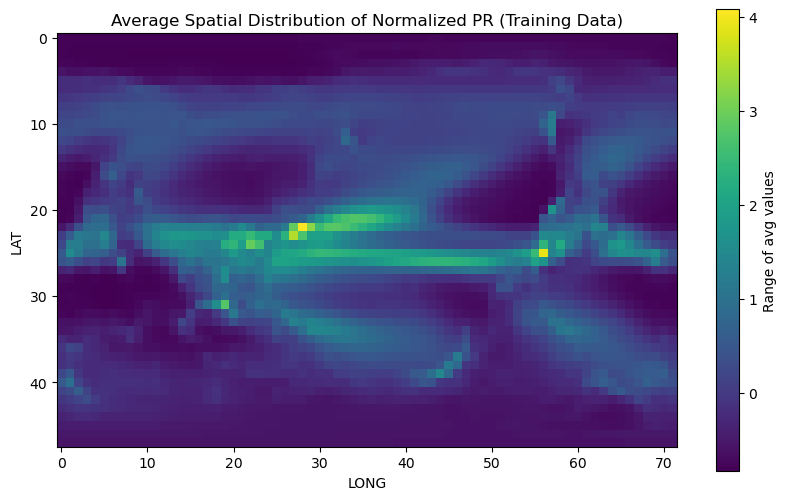

In [40]:
# plot TAS 
# select the data acrpss all trianin sample
tas_data_tensor = train_output[:, 0, :, :]
mean_spatial_distribution_tas = torch.mean(tas_data_tensor, dim=0)

mean_spatial_distribution_tas_np = mean_spatial_distribution_tas.numpy()


pr_data_tensor = train_output[:, 1, :, :]
mean_spatial_distribution_pr = torch.mean(pr_data_tensor, dim=0)
mean_spatial_distribution_pr_np = mean_spatial_distribution_pr.numpy()




# plot the heatmap
plt.figure(figsize=(10,6))
plt.imshow(mean_spatial_distribution_tas_np)
im_tas = plt.imshow(mean_spatial_distribution_tas_np)

plt.title(f'Average Spatial Distribution of Normalized {"TAS"} (Training Data)')
plt.xlabel('LONG') # Or Longitude if x_coords represent Longitude
plt.ylabel('LAT') # Or Latitude if y_coords represent Latitude

plt.colorbar(im_tas, label="Range of avg values")
plt.show()



# plot the heatmap
plt.figure(figsize=(10,6))
im_pr = plt.imshow(mean_spatial_distribution_pr_np)
plt.imshow(mean_spatial_distribution_pr_np)

plt.title(f'Average Spatial Distribution of Normalized {"PR"} (Training Data)')
plt.xlabel('LONG') # Or Longitude if x_coords represent Longitude
plt.ylabel('LAT') # Or Latitude if y_coords represent Latitude
plt.colorbar(im_pr, label="Range of avg values")
plt.show()

# Plot STD

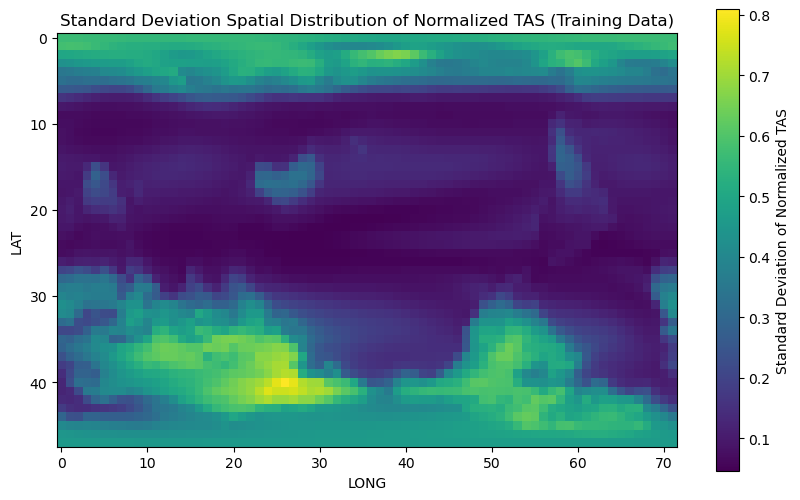

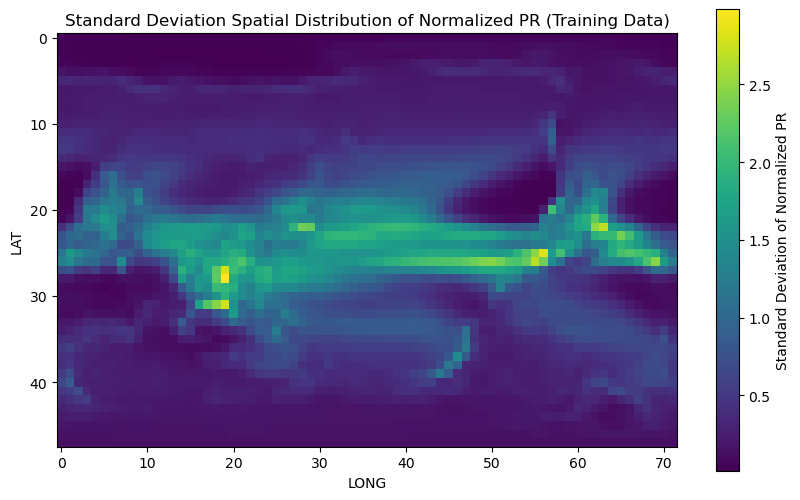

In [41]:
tas_data_tensor = train_output[:, 0, :, :]
std_spatial_distribution_tas = torch.std(tas_data_tensor, dim=0)
std_spatial_distribution_tas_np = std_spatial_distribution_tas.numpy()

# Calculate Standard Deviation for PR across time (dim=0)
pr_data_tensor = train_output[:, 1, :, :]
std_spatial_distribution_pr = torch.std(pr_data_tensor, dim=0)
std_spatial_distribution_pr_np = std_spatial_distribution_pr.numpy()


# plot the heatmap for TAS Standard Deviation
plt.figure(figsize=(10,6))
# Store the image object returned by imshow
im_tas_std = plt.imshow(std_spatial_distribution_tas_np)

plt.title(f'Standard Deviation Spatial Distribution of Normalized {"TAS"} (Training Data)')
plt.xlabel('LONG')
plt.ylabel('LAT')

# Add the colorbar for TAS Standard Deviation
# Pass the image object (im_tas_std) to colorbar
plt.colorbar(im_tas_std, label='Standard Deviation of Normalized TAS')
plt.show()


# plot the heatmap for PR Standard Deviation
plt.figure(figsize=(10,6))
# Store the image object returned by imshow
im_pr_std = plt.imshow(std_spatial_distribution_pr_np)

plt.title(f'Standard Deviation Spatial Distribution of Normalized {"PR"} (Training Data)')
plt.xlabel('LONG')
plt.ylabel('LAT')

# Add the colorbar for PR Standard Deviation
# Pass the image object (im_pr_std) to colorbar
plt.colorbar(im_pr_std, label='Standard Deviation of Normalized PR')
plt.show()

# Lets visualize input vars

In [42]:
print(in_vars)
train_input = cdm.train_dataset.inputs
train_input.shape

['CO2', 'SO2', 'CH4', 'BC', 'rsdt']


torch.Size([2703, 5, 48, 72])

## Here i used ai to write a loop to generate heatmaps

Processing variable: CO2 (Index 0)


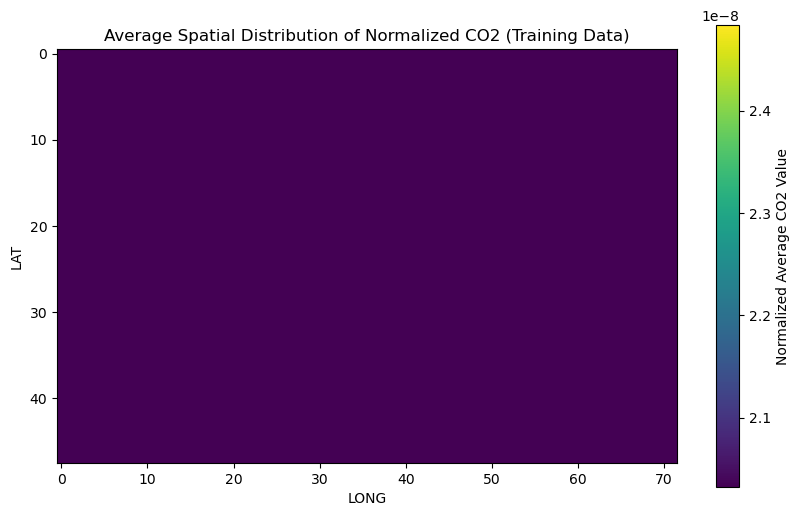

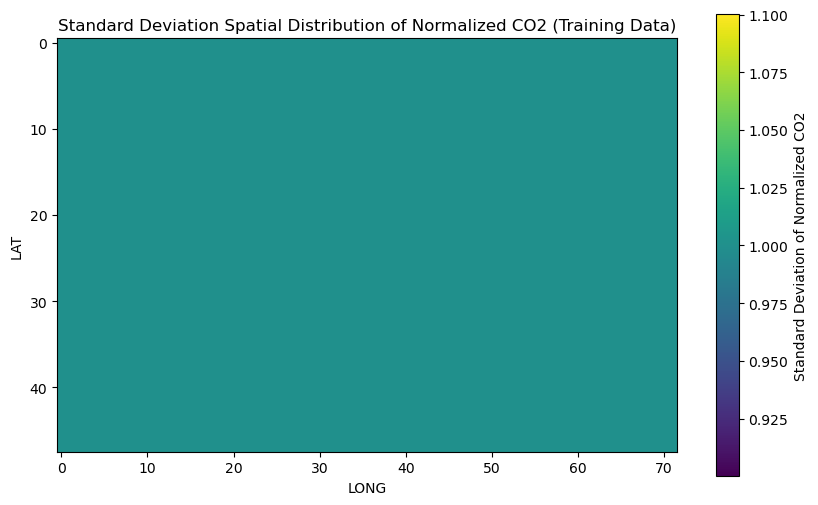

Processing variable: SO2 (Index 1)


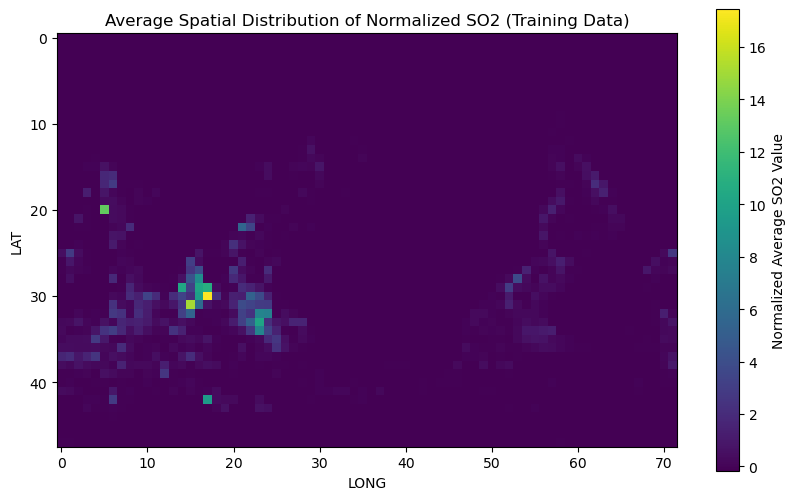

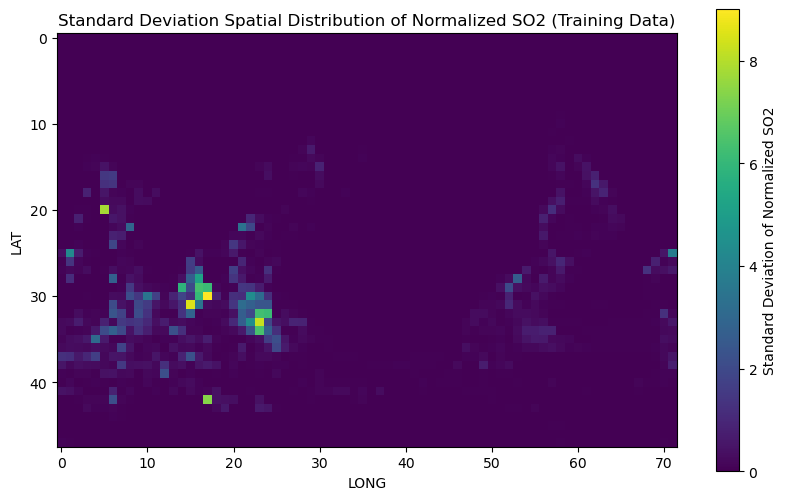

Processing variable: CH4 (Index 2)


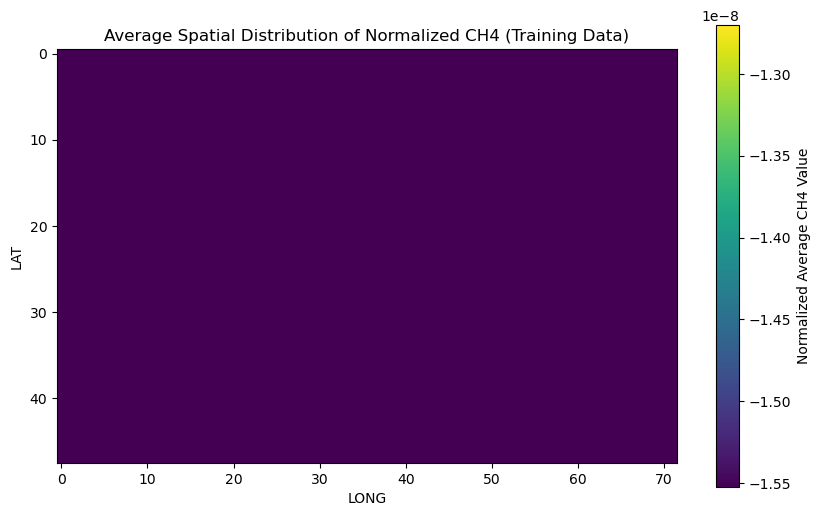

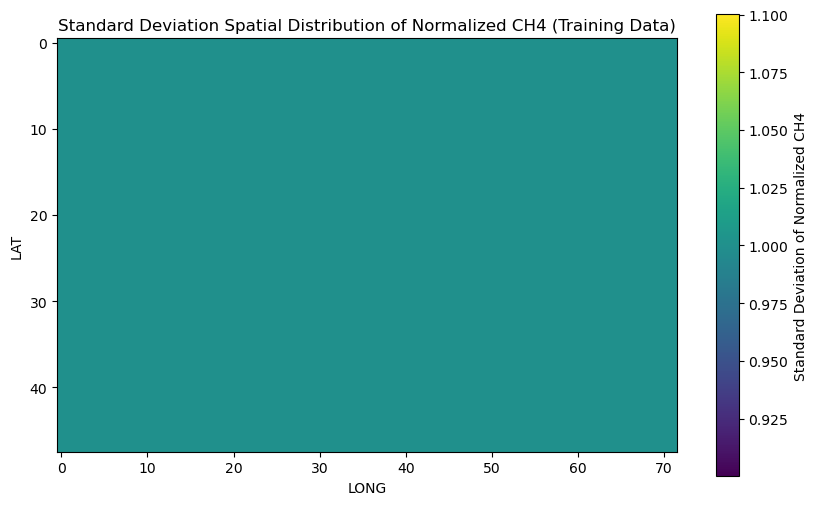

Processing variable: BC (Index 3)


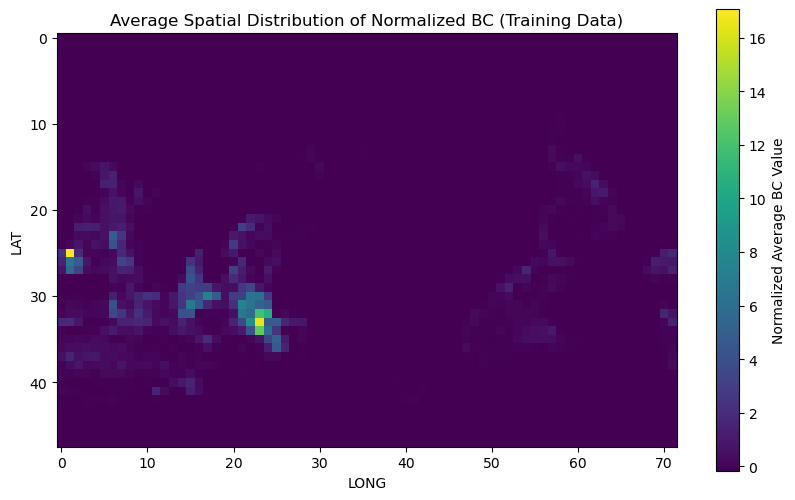

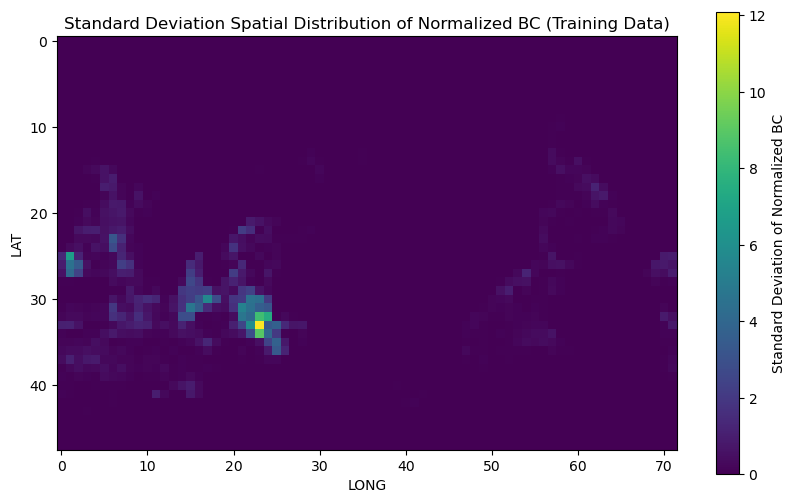

Processing variable: rsdt (Index 4)


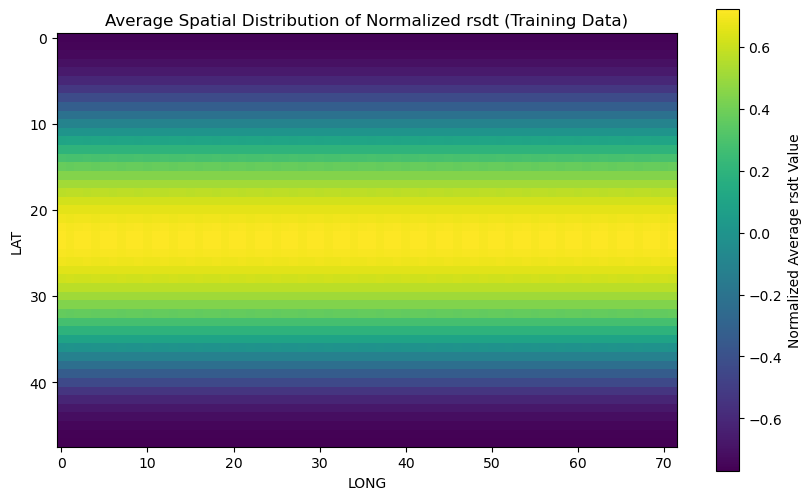

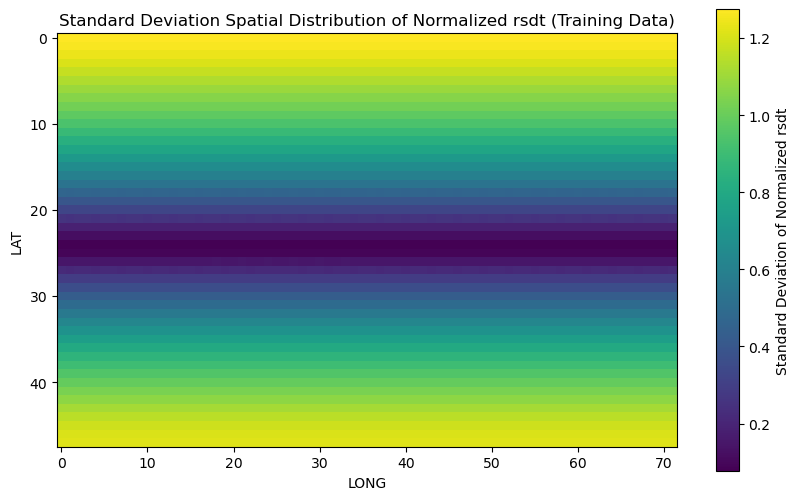

In [43]:
for i, var_name in enumerate(in_vars):

    print(f"Processing variable: {var_name} (Index {i})")

    # Select the data for the current input variable across all time samples
    # Shape: (time, y, x) -> (2943, 48, 72)
    variable_data_tensor = train_input[:, i, :, :]

    # --- Calculate and Plot Mean Spatial Distribution ---

    # Calculate the mean across the time dimension (dim=0)
    # Result shape: (y, x) -> (48, 72)
    mean_spatial_distribution = torch.mean(variable_data_tensor, dim=0)
    mean_spatial_distribution_np = mean_spatial_distribution.numpy()

    # Plot the heatmap for the Mean
    plt.figure(figsize=(10,6))
    im_mean = plt.imshow(mean_spatial_distribution_np) # Store the image object

    plt.title(f'Average Spatial Distribution of Normalized {var_name} (Training Data)')
    plt.xlabel('LONG')
    plt.ylabel('LAT')

    # Add the colorbar for the Mean
    plt.colorbar(im_mean, label=f'Normalized Average {var_name} Value')
    plt.show()


    # --- Calculate and Plot Standard Deviation Spatial Distribution ---

    # Calculate the standard deviation across the time dimension (dim=0)
    # Result shape: (y, x) -> (48, 72)
    std_spatial_distribution = torch.std(variable_data_tensor, dim=0)
    std_spatial_distribution_np = std_spatial_distribution.numpy()

    # Plot the heatmap for the Standard Deviation
    plt.figure(figsize=(10,6))
    im_std = plt.imshow(std_spatial_distribution_np) # Store the image object

    plt.title(f'Standard Deviation Spatial Distribution of Normalized {var_name} (Training Data)')
    plt.xlabel('LONG')
    plt.ylabel('LAT')

    # Add the colorbar for the Standard Deviation
    plt.colorbar(im_std, label=f'Standard Deviation of Normalized {var_name}')
    plt.show()

In [44]:
# lets Describe how the distribution changes as a function of the SSP scenario and/or year.


### ⚡ ClimateEmulationModule: Lightning Wrapper for Climate Model Emulation

This is the core model wrapper built with **PyTorch Lightning**, which organizes the training, validation, and testing logic for the climate emulation task. Lightning abstracts away much of the boilerplate code in PyTorch-based deep learning workflows, making it easier to scale models.

#### ✅ Key Features

- **`training_step` / `validation_step` / `test_step`**: Standard Lightning hooks for computing loss and predictions at each stage. The loss used is **Mean Squared Error (MSE)**.

- **Normalization-aware outputs**:
  - During validation and testing, predictions and targets are denormalized before evaluation using stored mean/std statistics.
  - This ensures evaluation is done in real-world units (Kelvin and mm/day).

- **Metric Evaluation** via `_evaluate()`:
  For each variable (`tas`, `pr`), it calculates:
  - **Monthly Area-Weighted RMSE**
  - **Time-Mean RMSE** (RMSE on 10-year average's)
  - **Time-Stddev MAE** (MAE on 10-year standard deviation; a measure of temporal variability)
    
  These metrics reflect the competition's evaluation criteria and are logged and printed.

- **Kaggle Submission Writer**:
  After testing, predictions are saved to a `.csv` file in the required Kaggle format via `_save_submission()`.

- **Saving Predictions for Visualization**:
  - Validation predictions are saved tao `val_preds.npy` and `val_trues.npy`
  - These can be loaded later for visual inspection of the model's performance.

 🔧 **Feel free to modify any part of this module** (loss functions, evaluation, training logic) to better suit your model or training pipeline / Use pure PyTorch etc.

⚠️ The **final submission `.csv` file must strictly follow the format and naming convention used in `_save_submission()`**, as these `ID`s are used to match predictions to the hidden test set during evaluation.



In [58]:
import pandas as pd

class ClimateEmulationModule(pl.LightningModule):
    def __init__(self, model, learning_rate=1e-4):
        super().__init__()
        self.model = model
        self.save_hyperparameters(ignore=['model']) # Save all hyperparameters except the model to self.hparams.<param_name>
        self.criterion = nn.MSELoss()
        self.normalizer = None
        self.val_preds, self.val_targets = [], []
        self.test_preds, self.test_targets = [], []
        self.training_loss = []
        self.val_loss = []

    def forward(self, x):
        return self.model(x)

    def return_t_loss(self):
        return self.training_loss

    def return_v_loss(self):
        return self.val_loss
    
    def on_fit_start(self):
        self.normalizer = self.trainer.datamodule.normalizer  # Get the normalizer from the datamodule (see above)

    def training_step(self, batch, batch_idx):
        x, y = batch # Unpack inputs and targets (this is the output of the _getitem_ method in the Dataset above)
        y_hat = self(x)   # Forward pass
        loss = self.criterion(y_hat, y)  # Calculate loss
        self.training_loss.append(loss.item())  # Store loss for tracking
        self.log("train/loss", loss)  # Log loss for tracking
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.criterion(y_hat, y)
        self.val_loss.append(loss.item())  # Store loss for tracking
        self.log("val/loss", loss)

        y_hat_np = self.normalizer.inverse_transform_output(y_hat.detach().cpu().numpy())
        y_np = self.normalizer.inverse_transform_output(y.detach().cpu().numpy())
        self.val_preds.append(y_hat_np)
        self.val_targets.append(y_np)

        return loss

    def on_validation_epoch_end(self):
        # Concatenate all predictions and ground truths from each val step/batch into one array
        preds = np.concatenate(self.val_preds, axis=0)
        trues = np.concatenate(self.val_targets, axis=0)
        self._evaluate(preds, trues, phase="val")
        np.save("val_preds.npy", preds)
        np.save("val_trues.npy", trues)
        self.val_preds.clear()
        self.val_targets.clear()

    def test_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        y_hat_np = self.normalizer.inverse_transform_output(y_hat.detach().cpu().numpy())
        y_np = y.detach().cpu().numpy()
        self.test_preds.append(y_hat_np)
        self.test_targets.append(y_np)

    def on_test_epoch_end(self):
        # Concatenate all predictions and ground truths from each test step/batch into one array
        preds = np.concatenate(self.test_preds, axis=0)
        trues = np.concatenate(self.test_targets, axis=0)
        self._evaluate(preds, trues, phase="test")
        self._save_submission(preds)
        self.test_preds.clear()
        self.test_targets.clear()

    def configure_optimizers(self):
        return optim.AdamW(self.parameters(), lr=self.hparams.learning_rate)

    def _evaluate(self, preds, trues, phase="val"):
        datamodule = self.trainer.datamodule
        area_weights = datamodule.get_lat_weights()
        lat, lon = datamodule.get_coords()
        time = np.arange(preds.shape[0])
        output_vars = datamodule.output_vars

        for i, var in enumerate(output_vars):
            p = preds[:, i]
            t = trues[:, i]
            p_xr = xr.DataArray(p, dims=["time", "y", "x"], coords={"time": time, "y": lat, "x": lon})
            t_xr = xr.DataArray(t, dims=["time", "y", "x"], coords={"time": time, "y": lat, "x": lon})

            # RMSE
            rmse = np.sqrt(((p_xr - t_xr) ** 2).weighted(area_weights).mean(("time", "y", "x")).item())
            # RMSE of time-mean
            mean_rmse = np.sqrt(((p_xr.mean("time") - t_xr.mean("time")) ** 2).weighted(area_weights).mean(("y", "x")).item())
            # MAE of time-stddev
            std_mae = np.abs(p_xr.std("time") - t_xr.std("time")).weighted(area_weights).mean(("y", "x")).item()

            print(f"[{phase.upper()}] {var}: RMSE={rmse:.4f}, Time-Mean RMSE={mean_rmse:.4f}, Time-Stddev MAE={std_mae:.4f}")
            self.log_dict({
                f"{phase}/{var}/rmse": rmse,
                f"{phase}/{var}/time_mean_rmse": mean_rmse,
                f"{phase}/{var}/time_std_mae": std_mae,
            })

    def _save_submission(self, predictions):
        datamodule = self.trainer.datamodule
        lat, lon = datamodule.get_coords()
        output_vars = datamodule.output_vars
        time = np.arange(predictions.shape[0])

        rows = []
        for t_idx, t in enumerate(time):
            for var_idx, var in enumerate(output_vars):
                for y_idx, y in enumerate(lat):
                    for x_idx, x in enumerate(lon):
                        row_id = f"t{t_idx:03d}_{var}_{y:.2f}_{x:.2f}"
                        pred = predictions[t_idx, var_idx, y_idx, x_idx]
                        rows.append({"ID": row_id, "Prediction": pred})

        df = pd.DataFrame(rows)
        os.makedirs("submissions", exist_ok=True)
        filepath = f"submissions/kaggle_submission_{datetime.now().strftime('%Y%m%d_%H%M%S')}.csv"
        df.to_csv(filepath, index=False)
        print(f"✅ Submission saved to: {filepath}")

### ⚡ Training & Evaluation with PyTorch Lightning

This block sets up and runs the training and testing pipeline using **PyTorch Lightning’s `Trainer`**, which abstracts away much of the boilerplate in deep learning workflows.

- **Modular Setup**:
  - `datamodule`: Handles loading, normalization, and batching of climate data.
  - `model`: A convolutional neural network that maps climate forcings to predicted outputs.
  - `lightning_module`: Wraps the model with training/validation/test logic and metric evaluation.

- **Trainer Flexibility**:
  The `Trainer` accepts a wide range of configuration options from `config["trainer"]`, including:
  - Number of epochs
  - Precision (e.g., 16-bit or 32-bit)
  - Device configuration (CPU, GPU, or TPU)
  - Determinism, logging, callbacks, and more

In [46]:
datamodule = ClimateDataModule(**config["data"])
model = SimpleCNN(
    n_input_channels=len(config["data"]["input_vars"]),
    n_output_channels=len(config["data"]["output_vars"]),
    **{k: v for k, v in config["model"].items() if k != "type"}
)
lightning_module = ClimateEmulationModule(model, learning_rate=config["training"]["lr"])
trainer = pl.Trainer(**config["trainer"])
trainer.fit(lightning_module, datamodule=datamodule)   # Training

TypeError: SimpleCNN.__init__() got an unexpected keyword argument 'init_features'

In [49]:
datamodule = ClimateDataModule(**config["data"])
model = SimpleUNET(
    n_input_channels=len(config["data"]["input_vars"]),
    n_output_channels=len(config["data"]["output_vars"]),
    **{k: v for k, v in config["model"].items() if k != "type"}
)
lightning_module = ClimateEmulationModule(model, learning_rate=config["training"]["lr"])

trainer = pl.Trainer(**config["trainer"])
 # Training

/home/mpodgore/.local/lib/python3.11/site-packages/lightning/fabric/connector.py:571: `precision=16` is supported for historical reasons but its usage is discouraged. Please set your precision to 16-mixed instead!
Using 16bit Automatic Mixed Precision (AMP)
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [50]:
trainer.fit(lightning_module, datamodule=datamodule)  

2025-05-16 18:30:02.392060: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747420202.412944    3825 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747420202.419502    3825 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-16 18:30:02.442087: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Creating dataset with 2703 samples...
Creating dataset with 360 samples...
Creating dataset with 360 samples...


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type       | Params | Mode 
-------------------------------------------------
0 | model     | SimpleUNET | 7.8 M  | train
1 | criterion | MSELoss    | 0      | train
-------------------------------------------------
7.8 M     Trainable params
0         Non-trainable params
7.8 M     Total params
31.148    Total estimated model params size (MB)
75        Modules in train mode
0         Modules in eval mode
/home/mpodgore/.local/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=63` in the `DataLoader` to improve performance.
/home/mpodgore/.local/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of 

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=4.6487, Time-Mean RMSE=3.1305, Time-Stddev MAE=1.1821
[VAL] pr: RMSE=2.7544, Time-Mean RMSE=0.8556, Time-Stddev MAE=1.5579


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=4.1989, Time-Mean RMSE=2.5537, Time-Stddev MAE=1.0921
[VAL] pr: RMSE=2.6273, Time-Mean RMSE=0.5963, Time-Stddev MAE=1.3841


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=3.3123, Time-Mean RMSE=2.0185, Time-Stddev MAE=0.8187
[VAL] pr: RMSE=2.2976, Time-Mean RMSE=0.6119, Time-Stddev MAE=1.0900


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=2.7432, Time-Mean RMSE=1.7121, Time-Stddev MAE=0.6342
[VAL] pr: RMSE=2.0988, Time-Mean RMSE=0.5267, Time-Stddev MAE=0.8869


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=2.3172, Time-Mean RMSE=1.4154, Time-Stddev MAE=0.6740
[VAL] pr: RMSE=2.0443, Time-Mean RMSE=0.4468, Time-Stddev MAE=0.8575


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=2.2119, Time-Mean RMSE=1.2649, Time-Stddev MAE=0.6306
[VAL] pr: RMSE=2.0469, Time-Mean RMSE=0.4408, Time-Stddev MAE=0.8506


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=2.4018, Time-Mean RMSE=1.3833, Time-Stddev MAE=0.7340
[VAL] pr: RMSE=2.1602, Time-Mean RMSE=0.5587, Time-Stddev MAE=0.9803


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=1.9466, Time-Mean RMSE=1.1050, Time-Stddev MAE=0.5164
[VAL] pr: RMSE=1.9944, Time-Mean RMSE=0.3575, Time-Stddev MAE=0.8165


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=1.9108, Time-Mean RMSE=1.0432, Time-Stddev MAE=0.4913
[VAL] pr: RMSE=1.9943, Time-Mean RMSE=0.3619, Time-Stddev MAE=0.8105


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=1.8693, Time-Mean RMSE=1.0329, Time-Stddev MAE=0.4750
[VAL] pr: RMSE=1.9914, Time-Mean RMSE=0.3648, Time-Stddev MAE=0.7735


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=1.8724, Time-Mean RMSE=1.0535, Time-Stddev MAE=0.4345
[VAL] pr: RMSE=1.9933, Time-Mean RMSE=0.3900, Time-Stddev MAE=0.7801


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=1.9335, Time-Mean RMSE=1.1210, Time-Stddev MAE=0.5107
[VAL] pr: RMSE=1.9808, Time-Mean RMSE=0.3438, Time-Stddev MAE=0.7912


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=1.8773, Time-Mean RMSE=1.0970, Time-Stddev MAE=0.4926
[VAL] pr: RMSE=1.9756, Time-Mean RMSE=0.3173, Time-Stddev MAE=0.8156


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=1.7641, Time-Mean RMSE=0.8850, Time-Stddev MAE=0.4651
[VAL] pr: RMSE=1.9930, Time-Mean RMSE=0.3771, Time-Stddev MAE=0.8416


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=1.7869, Time-Mean RMSE=0.9239, Time-Stddev MAE=0.4670
[VAL] pr: RMSE=1.9662, Time-Mean RMSE=0.2882, Time-Stddev MAE=0.7681


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=1.8514, Time-Mean RMSE=1.0478, Time-Stddev MAE=0.4620
[VAL] pr: RMSE=1.9691, Time-Mean RMSE=0.2903, Time-Stddev MAE=0.7622


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=1.7182, Time-Mean RMSE=0.8980, Time-Stddev MAE=0.4132
[VAL] pr: RMSE=1.9791, Time-Mean RMSE=0.3653, Time-Stddev MAE=0.7964


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=1.7841, Time-Mean RMSE=0.9840, Time-Stddev MAE=0.4408
[VAL] pr: RMSE=1.9652, Time-Mean RMSE=0.2937, Time-Stddev MAE=0.8031


`Trainer.fit` stopped: `max_epochs=18` reached.


In [51]:
trainer.test(lightning_module, datamodule=datamodule) 

Creating dataset with 2703 samples...
Creating dataset with 360 samples...
Creating dataset with 360 samples...


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/mpodgore/.local/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=63` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

[TEST] tas: RMSE=290.4220, Time-Mean RMSE=290.3846, Time-Stddev MAE=3.4392
[TEST] pr: RMSE=4.2463, Time-Mean RMSE=3.7915, Time-Stddev MAE=1.3600
✅ Submission saved to: submissions/kaggle_submission_20250516_183612.csv


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test/pr/rmse        │     4.24629545211792      │
│  test/pr/time_mean_rmse   │    3.7915375232696533     │
│   test/pr/time_std_mae    │    1.3600409030914307     │
│       test/tas/rmse       │     290.4220275878906     │
│  test/tas/time_mean_rmse  │     290.3846130371094     │
│   test/tas/time_std_mae   │    3.4392380714416504     │
└───────────────────────────┴───────────────────────────┘

[{'test/tas/rmse': 290.4220275878906,
  'test/tas/time_mean_rmse': 290.3846130371094,
  'test/tas/time_std_mae': 3.4392380714416504,
  'test/pr/rmse': 4.24629545211792,
  'test/pr/time_mean_rmse': 3.7915375232696533,
  'test/pr/time_std_mae': 1.3600409030914307}]

# Test model

**IMPORTANT:** Please note that the test metrics will be bad because the test targets have been corrupted on the public Kaggle dataset.
The purpose of testing below is to generate the Kaggle submission file based on your model's predictions, which you can submit to the competition.

### Plotting Utils


In [52]:
def plot_comparison(true_xr, pred_xr, title, cmap='viridis', diff_cmap='RdBu_r', metric=None):
    fig, axs = plt.subplots(1, 3, figsize=(18, 6))

    vmin = min(true_xr.min().item(), pred_xr.min().item())
    vmax = max(true_xr.max().item(), pred_xr.max().item())

    # Ground truth
    true_xr.plot(ax=axs[0], cmap=cmap, vmin=vmin, vmax=vmax, add_colorbar=True)
    axs[0].set_title(f"{title} (Ground Truth)")

    # Prediction
    pred_xr.plot(ax=axs[1], cmap=cmap, vmin=vmin, vmax=vmax, add_colorbar=True)
    axs[1].set_title(f"{title} (Prediction)")

    # Difference
    diff = pred_xr - true_xr
    abs_max = np.max(np.abs(diff))
    diff.plot(ax=axs[2], cmap=diff_cmap, vmin=-abs_max, vmax=abs_max, add_colorbar=True)
    axs[2].set_title(f"{title} (Difference) {f'- {metric:.4f}' if metric else ''}")

    plt.tight_layout()
    plt.show()


### 🖼️ Visualizing Validation Predictions

This cell loads saved validation predictions and compares them to the ground truth using spatial plots. These visualizations help you qualitatively assess your model's performance.

For each output variable (`tas`, `pr`), we visualize:

- **📈 Time-Mean Map**: The 10-year average spatial pattern for both prediction and ground truth. Helps identify long-term biases or spatial shifts.
- **📊 Time-Stddev Map**: Shows the standard deviation across time for each grid cell — useful for assessing how well the model captures **temporal variability** at each location.
- **🕓 Random Timestep Sample**: Visual comparison of prediction vs ground truth for a single month. Useful for spotting fine-grained anomalies or errors in specific months.

> These plots provide intuition beyond metrics and are useful for debugging spatial or temporal model failures.


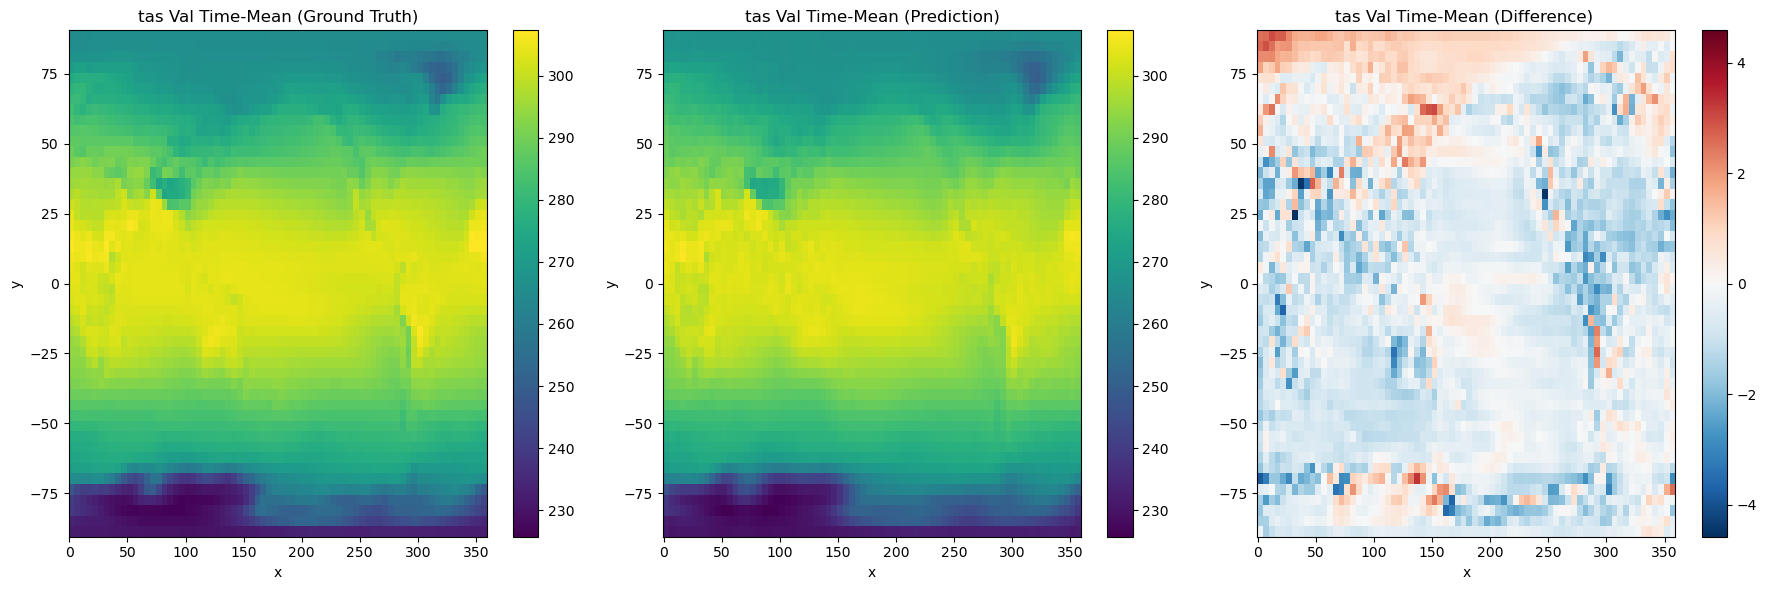

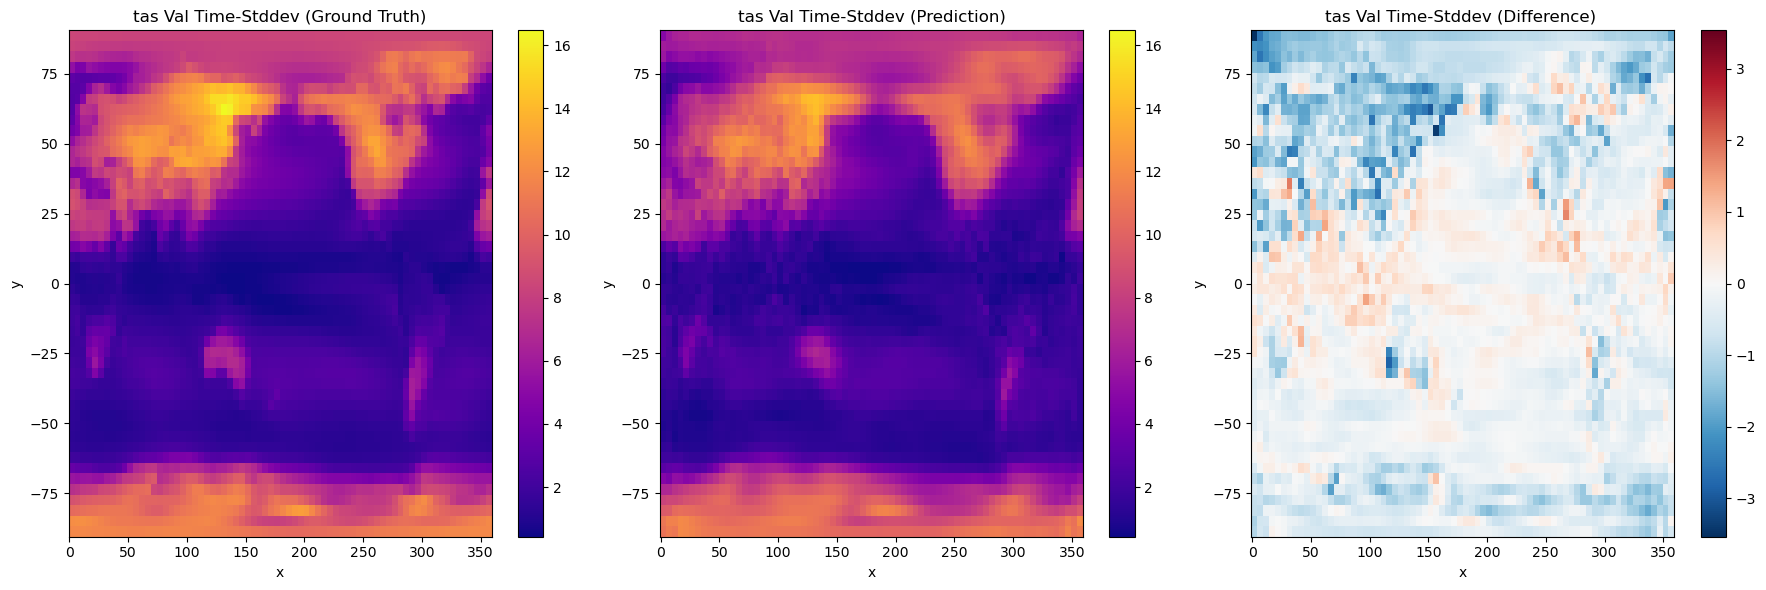

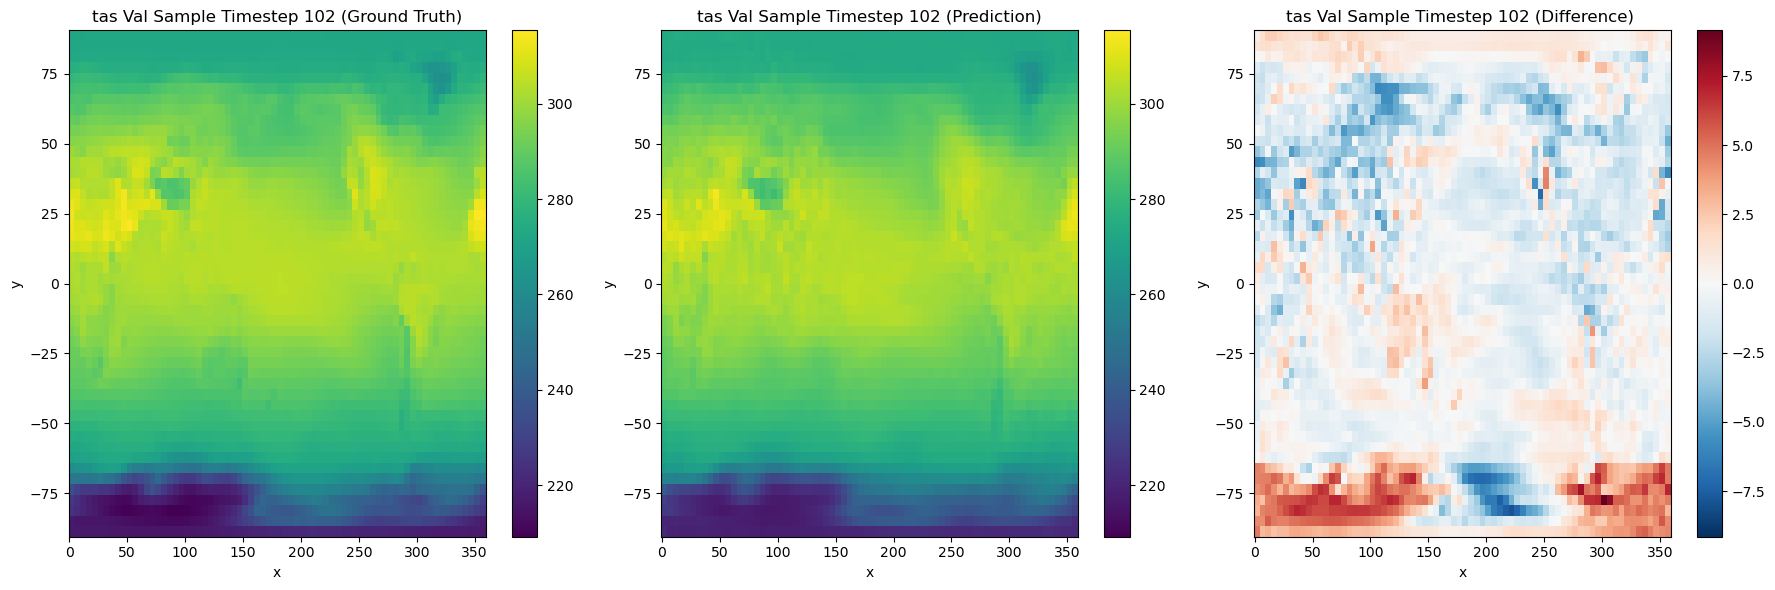

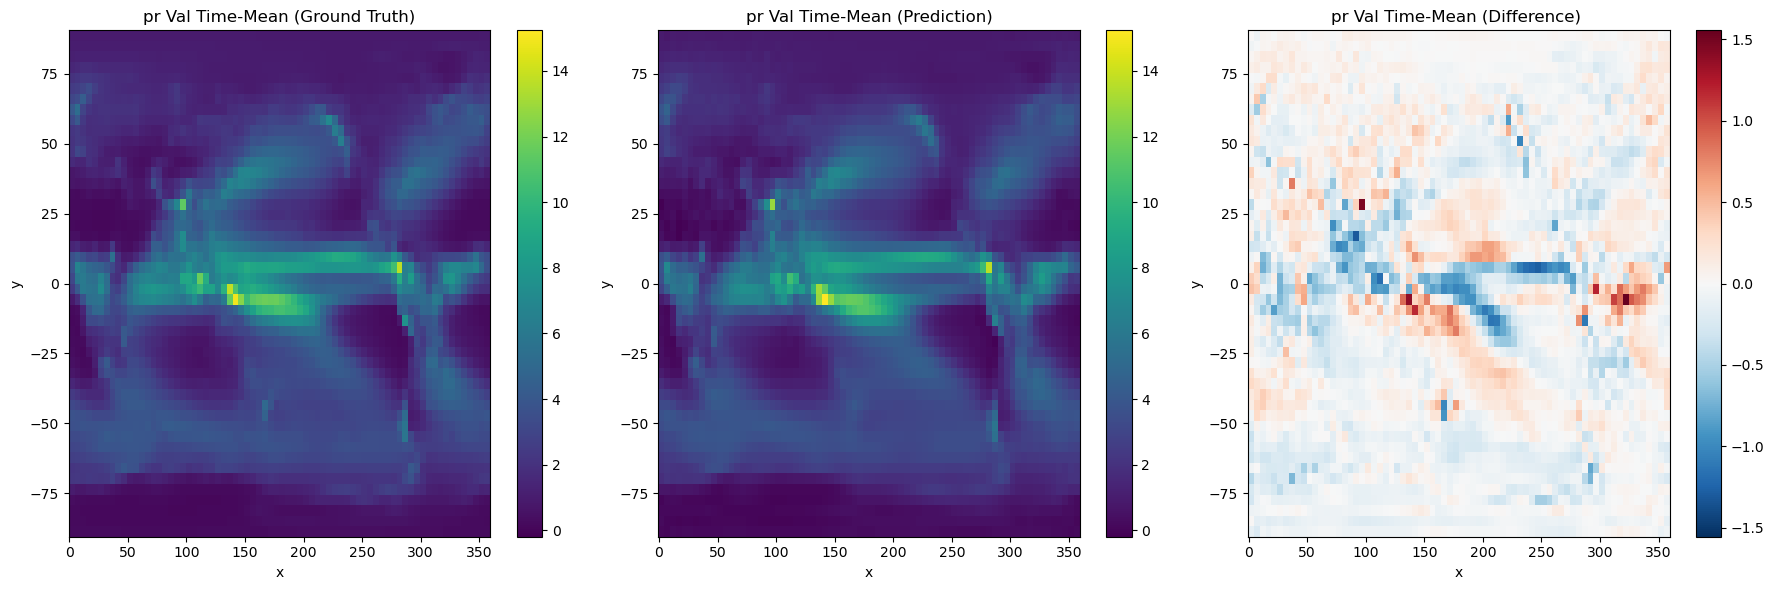

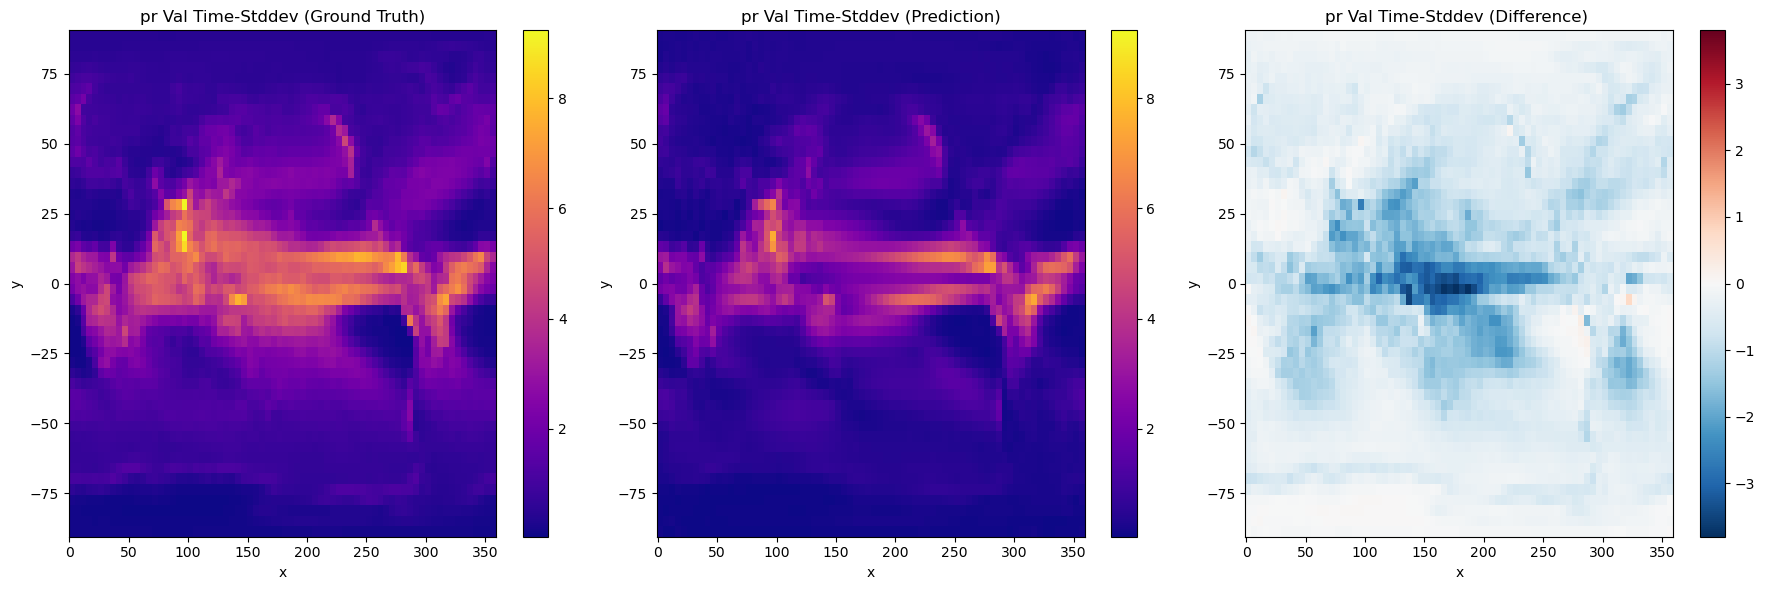

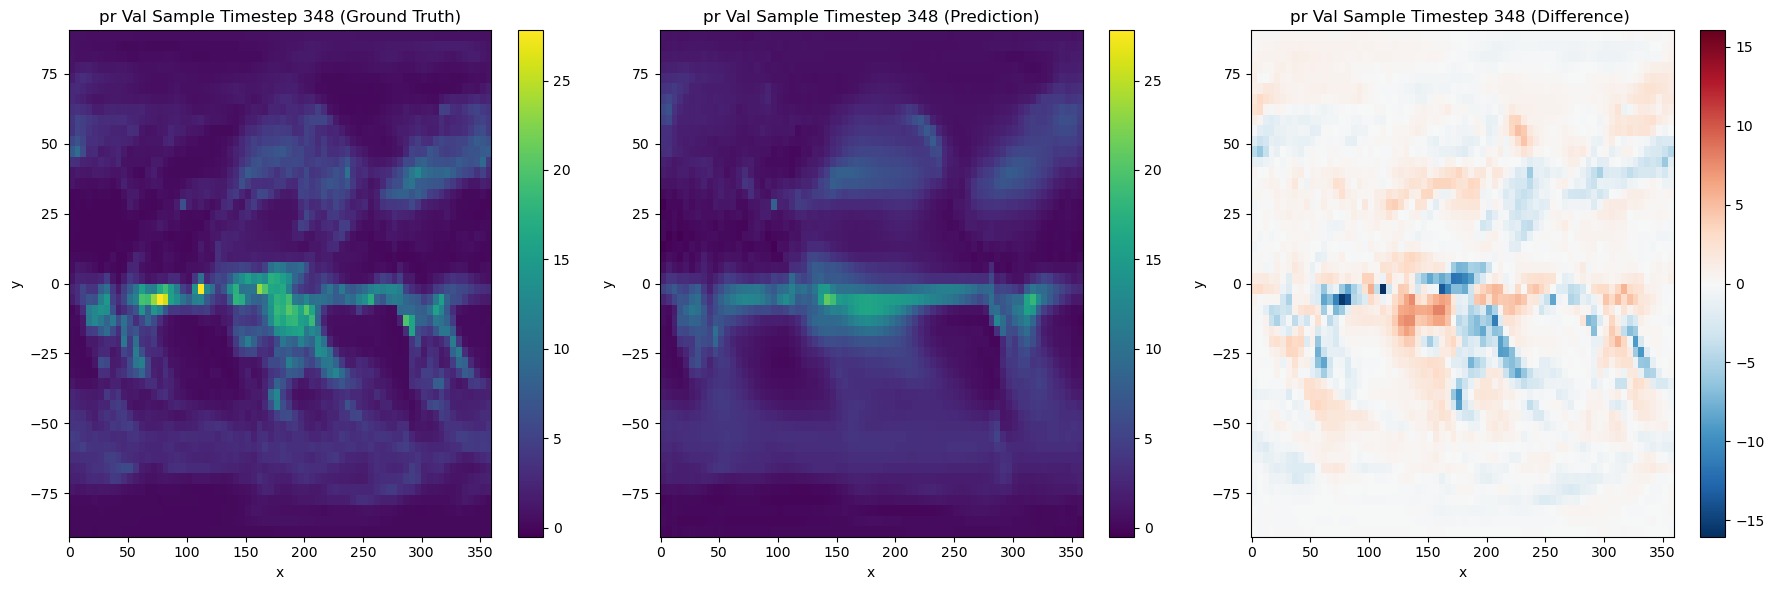

In [53]:
# Load validation predictions
# make sure to have run the validation loop at least once
val_preds = np.load("val_preds.npy")
val_trues = np.load("val_trues.npy")

lat, lon = datamodule.get_coords()
output_vars = datamodule.output_vars
time = np.arange(val_preds.shape[0])

for i, var in enumerate(output_vars):
    pred_xr = xr.DataArray(val_preds[:, i], dims=["time", "y", "x"], coords={"time": time, "y": lat, "x": lon})
    true_xr = xr.DataArray(val_trues[:, i], dims=["time", "y", "x"], coords={"time": time, "y": lat, "x": lon})

    # --- Time Mean ---
    plot_comparison(true_xr.mean("time"), pred_xr.mean("time"), f"{var} Val Time-Mean")

    # --- Time Stddev ---
    plot_comparison(true_xr.std("time"), pred_xr.std("time"), f"{var} Val Time-Stddev", cmap="plasma")

    # --- Random timestep ---
    t_idx = np.random.randint(0, len(time))
    plot_comparison(true_xr.isel(time=t_idx), pred_xr.isel(time=t_idx), f"{var} Val Sample Timestep {t_idx}")


In [ ]:
## Training Vs. Validation Loss

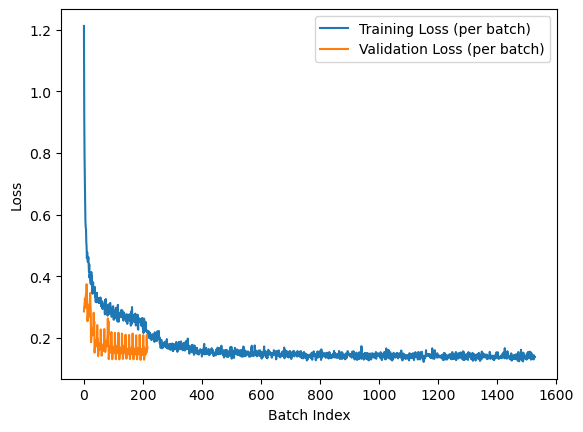

In [62]:

train_losses = trainer.model.training_loss  # List of batch losses
val_losses = trainer.model.val_loss          # List of validation batch losses

plt.plot(train_losses, label='Training Loss (per batch)')
plt.plot(val_losses, label='Validation Loss (per batch)')
plt.xlabel('Batch Index')
plt.ylabel('Loss')
plt.legend()
plt.show()


## 🧪 Final Notes

This notebook is meant to serve as a **baseline template** — a starting point to help you get up and running quickly with the climate emulation challenge.

You are **not** required to stick to this exact setup. In fact, we **encourage** you to:

- 🔁 Build on top of the provided `DataModule`. 
- 🧠 Use your own model architectures or training pipelines that you’re more comfortable with 
- ⚗️ Experiment with ideas  
- 🥇 Compete creatively to climb the Kaggle leaderboard  
- 🙌 Most importantly: **have fun** and **learn as much as you can** along the way

This challenge simulates a real-world scientific problem, and there’s no single "correct" approach — so be curious, experiment boldly, and make it your own!
